# LDAE Analysis

In this notebook, we will analyze the behavior and performance of LDAE model, specially we will focus on how the anomalious image will affect the semantic representation $y_{sem} = Enc(x_0)$. 

In [14]:
%load_ext autoreload
%autoreload 2
%cd "~/projects/spartDM"

## Seting up environment 

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
print(f"Paths:: {sys.path}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/kdang/projects/spartDM
Paths:: ['/home/kdang/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python310.zip', '/home/kdang/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10', '/home/kdang/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/lib-dynload', '', '/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages', '/home/kdang/projects/spartDM', '/tmp/tmpusdatbn2', '/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/setuptools/_vendor', '/home/kdang/projects']


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load Starmen Dataset

Load a sample with: normal, anomaly and ground truth mask 

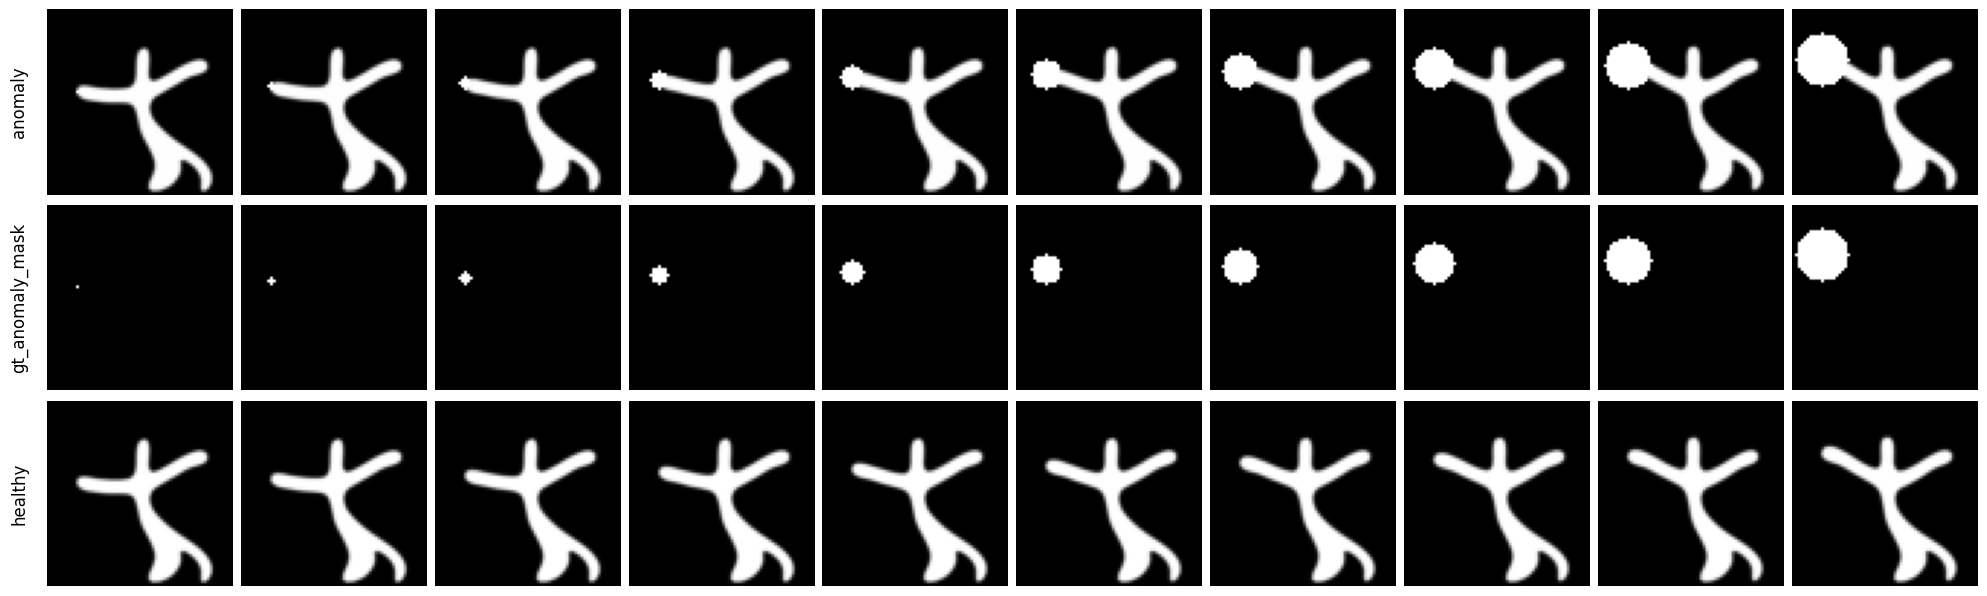

In [90]:
from src.ldae.utils import load_yaml_config
from src.data.datamodules import StarmenDataset
import torch
from monai.data import DataLoader
import numpy as np 
import matplotlib.pyplot as plt
from einops import rearrange

config = load_yaml_config('configs/starmen_diffae.yaml')  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset

DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"

test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split="gcircle10",
    nb_subject=None,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
test_ids = test_ds.ids

# Load the original (anomalious) image from test dataset by index
x_anos = [test_ds.get_images_by_id(id).squeeze() for id in test_ids]
x_anos = np.stack(x_anos).astype("float32")

# Load the groundtruth anomaly mask 
gt_paths = test_ds.datas["gt_path"].unique()
x_ano_gts = []
for id in test_ids:
    gt_path = test_ds.datas[test_ds.datas["id"] == id]["gt_path"].unique().item()
    gt = np.load(gt_path)
    x_ano_gts.append(gt)
x_ano_gts = np.stack(x_ano_gts)
x_ano_gts.shape

# Load the original healthy images
# healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
x_hts = []
for id in test_ids:
    for t in range(0, 10):
        ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
        ht = np.load(ht_path)
        x_hts.append(ht)
x_hts = np.stack(x_hts)
x_hts = rearrange(x_hts, "(b t) h w -> b t h w", b=10)
x_hts.shape

# Plot 1 example of healthy, anomlious and ground truth mask 
id = 0
x_ano, x_ano_gt, x_ht = x_anos[id], x_ano_gts[id], x_hts[id]

from src.utils import plot_comparison_starmen

plot_comparison_starmen(
    imgs = [x_ano, x_ano_gt, x_ht],
    labels=["anomaly", "gt_anomaly_mask", "healthy"],
    is_errors=[False, False, False],
    show=True
)

# Create torch.tensor from np.ndarray
x_anos = torch.tensor(x_anos, dtype=torch.float32)
x_ano_gts = torch.tensor(x_ano_gts, dtype=torch.float32)
x_hts = torch.tensor(x_hts, dtype=torch.float32)


## Load LDAE models

Now we will load the LDAE model which includes difference sub-models: 

- `GaussianDiffusion`: class that holds all of our methods for training, testing, stochastic encoders and decoders. 

- `AttentionSemanticEncoder`: nn.Module to extract the semantic representation from $x_0$

- `ShiftUnet`: conditioned UNet using AdapGN. 

Note: here we dont use the VAE module to compress our original input. 


In [91]:
from src.ldae import LatentDiffusionAutoencoders2D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ldae_ckpt = os.path.join(WORK_DIR, "representation-learning/checkpoints/best2.ckpt")

ldae = LatentDiffusionAutoencoders2D.load_from_checkpoint(ldae_ckpt, map_location=device)

Successfully loaded the pretrained decoder model.
Backbone model loaded successfully.
Frozen first 0 layers out of 344 in the backbone



## Semantic encoder

We will use SemanticEncoder to encode our input into nonspartial representation, and compare the difference between the original image, anomalous image to see the effect of anomalies on our semantic representation. 

In [92]:
encoder = ldae.ema_encoder
encoder.eval()
print(f"Embbed dim of Semantic encoder: {encoder.embedding_dim}")\

with torch.no_grad():

    # Send data to device
    x_anos.to(device)
    x_ano_gts.to(device)
    x_hts.to(device)

    # Choose 1 index example
    id = 0
    x_ano, x_ano_gt, x_ht = x_anos[[id]], x_ano_gts[[id]], x_hts[[id]]
    x_ano = rearrange(x_ano, "b t h w -> t b h w", b=1, t=10)
    x_ano_gt = rearrange(x_ano_gt, "b t h w -> t b h w", b=1, t=10)
    x_ht = rearrange(x_ht, "b t h w -> t b h w", b=1, t=10)

    # Generate semantic encoder
    ysem_ano = encoder(x_ano)
    ysem_ht = encoder(x_ht)

Embbed dim of Semantic encoder: 512


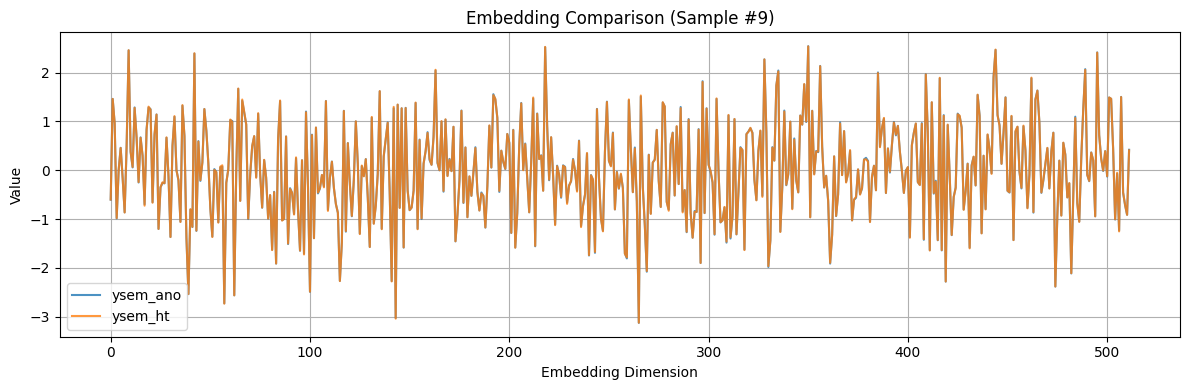

In [95]:
# Plot the difference of semantic embedding

i = 9  # change this from 0 to 9 if needed

vec_ano = ysem_ano[i].detach().cpu().numpy()
vec_ht = ysem_ht[i].detach().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.plot(vec_ano, label='ysem_ano', alpha=0.8)
plt.plot(vec_ht, label='ysem_ht', alpha=0.8)
plt.title(f'Embedding Comparison (Sample #{i})')
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

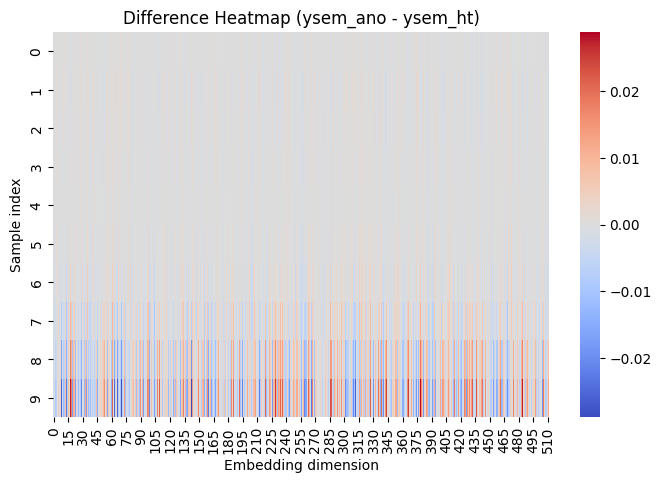

In [99]:
# Heatmap of difference

import seaborn as sns

# Difference heatmap
diff = (ysem_ano - ysem_ht).cpu().numpy()

plt.figure(figsize=(8, 5))
sns.heatmap(diff, cmap='coolwarm', center=0)
plt.title("Difference Heatmap (ysem_ano - ysem_ht)")
plt.xlabel("Embedding dimension")
plt.ylabel("Sample index")
plt.show()

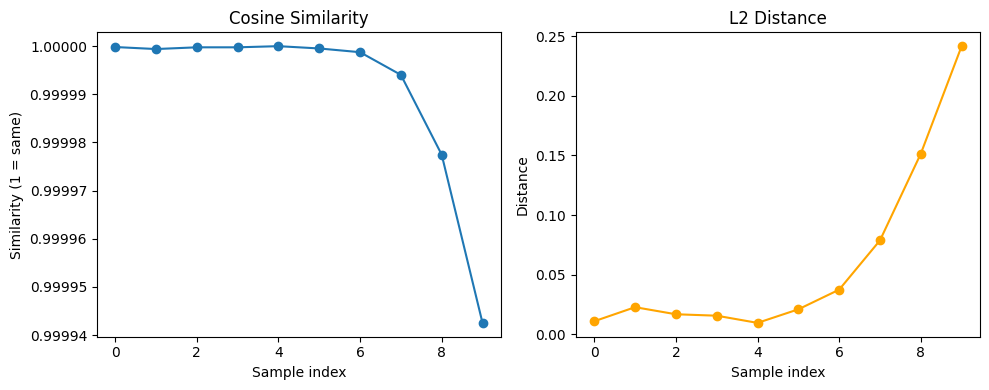

In [106]:
import torch
from matplotlib.ticker import FormatStrFormatter
import torch.nn.functional as F

# Cosine similarity per pair (higher = more similar)
cos_sim = F.cosine_similarity(ysem_ano, ysem_ht, dim=1)

# L2 distance (lower = more similar)
l2_dist = torch.norm(ysem_ano - ysem_ht, dim=1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(cos_sim.cpu(), marker='o')
plt.title('Cosine Similarity')
plt.xlabel('Sample index')
plt.ylabel('Similarity (1 = same)')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.5f')) 

plt.subplot(1, 2, 2)
plt.plot(l2_dist.cpu(), marker='o', color='orange')
plt.title('L2 Distance')
plt.xlabel('Sample index')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()


In these plot, the sample index is the time index of our sequence $t \in [1..10]$. We see that the difference in semantic encoder increases as the anomaly grows with time (here our anomaly type if growing circle). But the diff is not very much and basically the 2 embbed representation `ysem_ano` and `ysem_ht` is very much the same. 

Next, we will investigate how the model addes noise to image by using reversed generative process. This is the stochastic encoder. 

## Stochastic Encoder with ShiftUnet


In [108]:
decoder = ldae.ema_decoder

ddim_style = "ddim100"

x_T_inferred = ldae.gaussian_diffusion.representation_learning_ddim_encode(
                    ddim_style=ddim_style,
                    encoder=encoder,
                    decoder=decoder,
                    x_0=x_ano
                )

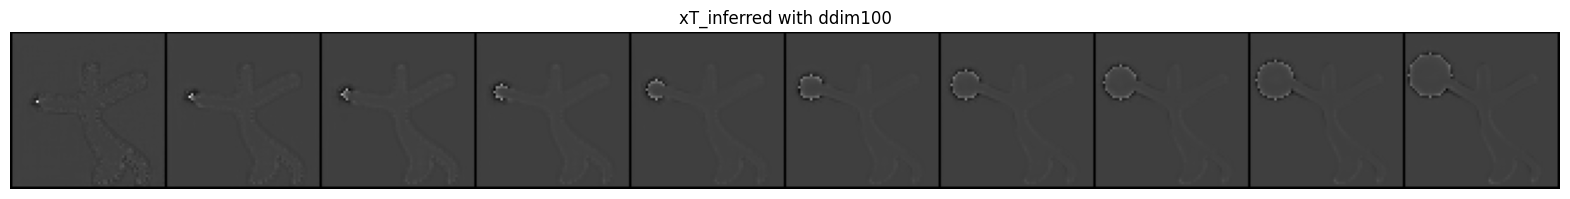

In [111]:
x_T_inferred.shape
import torchvision

grid = torchvision.utils.make_grid(x_T_inferred, nrow=10, normalize=True, padding=1)

plt.figure(figsize=(20, 4))  
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"xT_inferred with {ddim_style}")
plt.show()

encoding loop time step: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


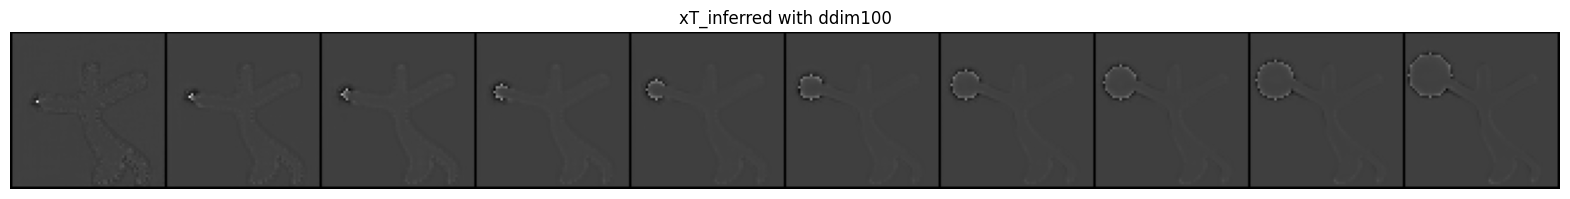

In [130]:
#Stochastic encode with DiffAE method: 

xT_inferred_diffae = ldae.gaussian_diffusion.representation_learning_diffae_encode(
                    ddim_style=ddim_style,
                    encoder=encoder,
                    unet=decoder,
                    x_0=x_ano
                )

grid = torchvision.utils.make_grid(xT_inferred_diffae, nrow=10, normalize=True, padding=1)

plt.figure(figsize=(20, 4))  
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"xT_inferred with {ddim_style}")
plt.show()

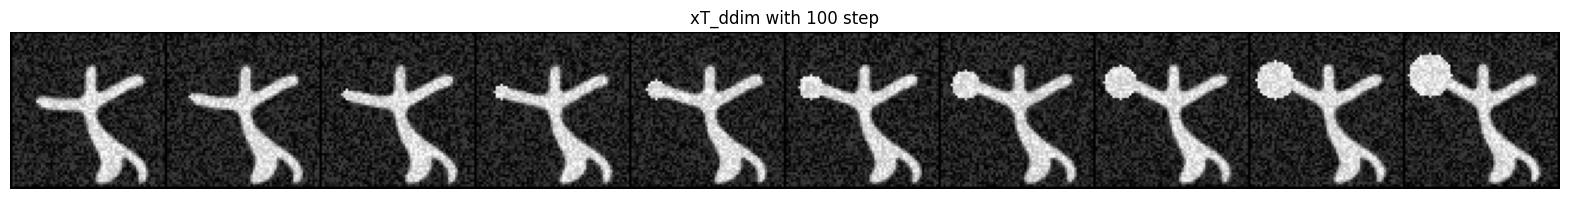

In [197]:
# Encode and Decode using standard DDIM (DMs) procedure

noise = torch.rand_like(x_ano).to(device)
step = 100
t = torch.full((10,), step, device=device)


from src.ldae.diffusion.ddim import DDIM

xT_ddim = ldae.gaussian_diffusion.q_sample(x_ano, t=t, noise=noise)
grid = torchvision.utils.make_grid(xT_ddim, nrow=10, normalize=True, padding=1)

plt.figure(figsize=(20, 4))  
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"xT_ddim with {step} step")
plt.show()

sampling loop time step: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


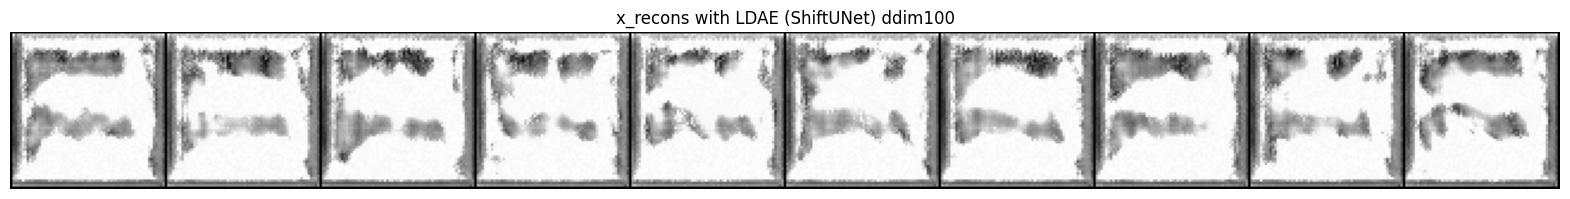

In [206]:
# Decode with LDAE (shiftUNet)

x_recons_ldae = ldae.gaussian_diffusion.representation_learning_ddim_sample(
    ddim_style="ddim10",
    encoder=ldae.ema_encoder,
    decoder=ldae.ema_decoder, 
    x_0=x_ano,
    # x_T=x_T_inferred
    x_T=torch.rand_like(x_ano, device=device)
)

grid = torchvision.utils.make_grid(x_recons_ldae, nrow=10, normalize=True, padding=1)

plt.figure(figsize=(20, 4))  
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"x_recons with LDAE (ShiftUNet) {ddim_style}")
plt.show()

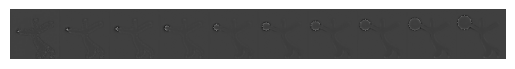

In [172]:
add_noise = x_T_inferred - x_ano
add_noise = rearrange(add_noise, "b c h w -> h (b c w)")
plt.imshow(add_noise, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
ldae_checkpoint = torch.load(ldae_ckpt, map_location=device)
ldae_checkpoint["state_dict"].keys()

ema_dict = {k: v for k, v in ldae_checkpoint["state_dict"].items() if "ema_decoder" in k }
ema_dict

{'ema_decoder.time_embed.0.weight': tensor([[ 0.1437,  0.1432, -0.0498,  ..., -0.2318,  0.1024, -0.2070],
         [ 0.1191,  0.0253, -0.0456,  ..., -0.0784,  0.0962, -0.0196],
         [ 0.0433, -0.0343,  0.1412,  ...,  0.1635, -0.0845, -0.0506],
         ...,
         [ 0.1423, -0.0007, -0.0769,  ...,  0.1050, -0.0538,  0.0714],
         [ 0.1421, -0.1145, -0.0371,  ...,  0.2067,  0.1292,  0.0835],
         [ 0.0941, -0.1270,  0.1414,  ...,  0.0953, -0.0704,  0.0344]]),
 'ema_decoder.time_embed.0.bias': tensor([-0.1276,  0.1761,  0.1644,  0.0869, -0.0938,  0.0938, -0.1714,  0.0885,
         -0.0379, -0.1874, -0.1806, -0.1512,  0.0334, -0.0624, -0.0716,  0.1957,
         -0.0233,  0.0842, -0.0369,  0.1024,  0.0780,  0.1377,  0.0513, -0.0453,
          0.1863,  0.0068, -0.0976,  0.0691, -0.0361, -0.1448,  0.0456, -0.0593,
         -0.0413, -0.0618, -0.0489, -0.0848,  0.0502,  0.1909, -0.0896, -0.1043,
         -0.1036,  0.0232,  0.0269, -0.1537,  0.0799, -0.1315,  0.1865,  0.0526,
    

In [188]:
ema_decoder = ldae.ema_decoder
decoder.state_dict()

OrderedDict([('time_embed.0.weight',
              tensor([[ 0.1437,  0.1432, -0.0498,  ..., -0.2318,  0.1024, -0.2070],
                      [ 0.1191,  0.0253, -0.0456,  ..., -0.0784,  0.0962, -0.0196],
                      [ 0.0433, -0.0343,  0.1412,  ...,  0.1635, -0.0845, -0.0506],
                      ...,
                      [ 0.1423, -0.0007, -0.0769,  ...,  0.1050, -0.0538,  0.0714],
                      [ 0.1421, -0.1145, -0.0371,  ...,  0.2067,  0.1292,  0.0835],
                      [ 0.0941, -0.1270,  0.1414,  ...,  0.0953, -0.0704,  0.0344]])),
             ('time_embed.0.bias',
              tensor([-0.1276,  0.1761,  0.1644,  0.0869, -0.0938,  0.0938, -0.1714,  0.0885,
                      -0.0379, -0.1874, -0.1806, -0.1512,  0.0334, -0.0624, -0.0716,  0.1957,
                      -0.0233,  0.0842, -0.0369,  0.1024,  0.0780,  0.1377,  0.0513, -0.0453,
                       0.1863,  0.0068, -0.0976,  0.0691, -0.0361, -0.1448,  0.0456, -0.0593,
                  